# Infill Montreal protocol halogens

1. Infill scenarios using [Silicone (see Lamboll et al., 2020)](https://doi.org/10.5194/gmd-13-5259-2020).

The harmonised, infilled scenarios are then run through MAGICC using [OpenSCM-Runner](https://github.com/openscm/openscm-runner).

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os.path

import dotenv
import matplotlib.pyplot as plt
import scmdata
import silicone.database_crunchers
import tqdm.autonotebook as tqdman
import xarray as xr

import utils

<IPython.core.display.Javascript object>

/data/ubuntu-znicholls/miniconda3/envs/one-earth-2022/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


<IPython.core.display.Javascript object>

In [3]:
dotenv.load_dotenv()

True

<IPython.core.display.Javascript object>

In [4]:
CRUNCHED_SCENARIOS_FILE = os.path.join(
    utils.DATA_DIR,
    "processed",
    "crunched-scenarios",
    "crunched-emissions-{}.nc".format(utils.SCENARIO_CREATION_ID),
)
CRUNCHED_SCENARIOS_FILE

'/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/processed/crunched-scenarios/crunched-emissions-7d7c42.nc'

<IPython.core.display.Javascript object>

In [5]:
OUT_FILE = os.path.join(
    utils.DATA_DIR,
    "processed",
    "harmonised-infilled-scenarios",
    "harmonised-infilled-emissions.nc",
)
os.makedirs(os.path.dirname(OUT_FILE), exist_ok=True)
OUT_FILE

'/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/processed/harmonised-infilled-scenarios/harmonised-infilled-emissions.nc'

<IPython.core.display.Javascript object>

In [6]:
crunched_scenarios = scmdata.ScmRun.from_nc(CRUNCHED_SCENARIOS_FILE)
crunched_scenarios["variable"] = crunched_scenarios["variable"].str.replace(
    "Harmonised", "Infilled"
)
crunched_scenarios

<ScmRun (timeseries: 3000, timepoints: 89)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2103-01-01T00:00:00
Meta:
	      co2_landuse_baseline_model co2_landuse_baseline_scenario  \
	0     Idealised from IMAGE 3.0.1        End deforestation 2030   
	1     Idealised from IMAGE 3.0.1        End deforestation 2030   
	2     Idealised from IMAGE 3.0.1        End deforestation 2030   
	3     Idealised from IMAGE 3.0.1        End deforestation 2030   
	4     Idealised from IMAGE 3.0.1        End deforestation 2030   
	...                          ...                           ...   
	2995                 IMAGE 3.0.1                 SSP1-Baseline   
	2996                 IMAGE 3.0.1                 SSP1-Baseline   
	2997                 IMAGE 3.0.1                 SSP1-Baseline   
	2998                 IMAGE 3.0.1                 SSP1-Baseline   
	2999                 IMAGE 3.0.1                 SSP1-Baseline   
	
	     landuse_pathways_quantile           model nonco2_landuse_baseline_model  \
	0 

<IPython.core.display.Javascript object>

In [7]:
rcmip_emissions = (
    scmdata.ScmRun(
        os.path.join(
            utils.DATA_DIR,
            "raw",
            "rcmip",
            "rcmip-emissions-annual-means-v5-1-0.csv",
        ),
        lowercase_cols=True,
    )
    .filter(scenario="ssp*", region="World")
    .filter(scenario="ssp370-*", keep=False)
)
display(rcmip_emissions.get_unique_meta("scenario"))

# cleaning and renaming
rcmip_emissions_clean = rcmip_emissions.drop_meta(["mip_era", "activity_id"])
rcmip_emissions_clean = utils.rcmip_to_openscm_runner(rcmip_emissions_clean).filter(
    variable=["Emissions|*|*", "Emissions|CO2"], keep=False
)

rcmip_emissions_clean

['ssp370',
 'ssp434',
 'ssp460',
 'ssp119',
 'ssp126',
 'ssp245',
 'ssp534-over',
 'ssp585']

<ScmRun (timeseries: 400, timepoints: 751)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2500-01-01T00:00:00
Meta:
	              model region scenario           unit           variable
	40          AIM/CGE  World   ssp370       Mt BC/yr       Emissions|BC
	56          AIM/CGE  World   ssp370      Mt CH4/yr      Emissions|CH4
	71          AIM/CGE  World   ssp370       Mt CO/yr       Emissions|CO
	98          AIM/CGE  World   ssp370   kt HFC125/yr   Emissions|HFC125
	99          AIM/CGE  World   ssp370  kt HFC134a/yr  Emissions|HFC134a
	...             ...    ...      ...            ...                ...
	8282  REMIND-MAGPIE  World   ssp585      Mt NH3/yr      Emissions|NH3
	8298  REMIND-MAGPIE  World   ssp585      Mt NOx/yr      Emissions|NOx
	8314  REMIND-MAGPIE  World   ssp585       Mt OC/yr       Emissions|OC
	8330  REMIND-MAGPIE  World   ssp585      Mt SO2/yr   Emissions|Sulfur
	8346  REMIND-MAGPIE  World   ssp585      Mt VOC/yr      Emissions|VOC
	
	[400 rows x 5 columns]

<IPython.core.display.Javascript object>

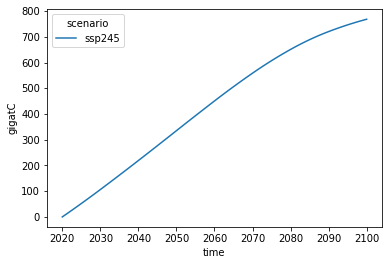

<IPython.core.display.Javascript object>

In [8]:
rcmip_emissions.filter(
    scenario="ssp245",
    variable="*CO2|MAGICC Fossil and Industrial",
    year=range(2020, 2100 + 1),
).resample("AS").convert_unit("GtC / yr").integrate().lineplot()

In [9]:
len(set(crunched_scenarios["variable"]))

52

<IPython.core.display.Javascript object>

In [10]:
rcmip_emissions_clean_variables = rcmip_emissions_clean.get_unique_meta("variable")
assert len(rcmip_emissions_clean_variables) == 50
to_infill_variables = set(rcmip_emissions_clean_variables) - set(
    crunched_scenarios.filter(nonco2_landuse_baseline_scenario="IMA15-TOT")["variable"]
)
display(len(to_infill_variables))
to_infill_variables

29

{'Emissions|C3F8',
 'Emissions|C4F10',
 'Emissions|C5F12',
 'Emissions|C7F16',
 'Emissions|C8F18',
 'Emissions|CCl4',
 'Emissions|CFC11',
 'Emissions|CFC113',
 'Emissions|CFC114',
 'Emissions|CFC115',
 'Emissions|CFC12',
 'Emissions|CH2Cl2',
 'Emissions|CH3Br',
 'Emissions|CH3CCl3',
 'Emissions|CH3Cl',
 'Emissions|CHCl3',
 'Emissions|HCFC141b',
 'Emissions|HCFC142b',
 'Emissions|HCFC22',
 'Emissions|HFC152a',
 'Emissions|HFC236fa',
 'Emissions|HFC365mfc',
 'Emissions|Halon1202',
 'Emissions|Halon1211',
 'Emissions|Halon1301',
 'Emissions|Halon2402',
 'Emissions|NF3',
 'Emissions|SO2F2',
 'Emissions|cC4F8'}

<IPython.core.display.Javascript object>

In [11]:
lead_variables = (
    (
        "Emissions|C2F6",
        (
            "Emissions|C3F8",
            "Emissions|C4F10",
            "Emissions|C5F12",
            "Emissions|C7F16",
            "Emissions|C8F18",
            "Emissions|CH3Br",
            "Emissions|CHCl3",
        ),
    ),
    (
        "Emissions|HFC134a",
        (
            "Emissions|CH2Cl2",
            "Emissions|HFC365mfc",
        ),
    ),
    (
        "Emissions|HFC4310mee",
        ("Emissions|HFC152a",),
    ),
    (
        "Emissions|SF6",
        ("Emissions|NF3",),
    ),
    (
        "Emissions|HFC245fa",
        ("Emissions|HFC236fa",),
    ),
    (
        "Emissions|CF4",
        (
            "Emissions|Halon1202",
            "Emissions|Halon1211",
            "Emissions|Halon1301",
            "Emissions|Halon2402",
            "Emissions|HCFC141b",
            "Emissions|HCFC142b",
            "Emissions|CCl4",
            "Emissions|CFC11",
            "Emissions|CFC12",
            "Emissions|CFC113",
            "Emissions|CFC114",
            "Emissions|CFC115",
            "Emissions|CH3CCl3",
            "Emissions|HCFC22",
            "Emissions|CH3Cl",
            "Emissions|SO2F2",
            "Emissions|cC4F8",
        ),
    ),
)
covered_variables = [i for v in lead_variables for i in v[1]]
missing = set(to_infill_variables) - set(covered_variables)
assert not missing, missing
covered_variables

['Emissions|C3F8',
 'Emissions|C4F10',
 'Emissions|C5F12',
 'Emissions|C7F16',
 'Emissions|C8F18',
 'Emissions|CH3Br',
 'Emissions|CHCl3',
 'Emissions|CH2Cl2',
 'Emissions|HFC365mfc',
 'Emissions|HFC152a',
 'Emissions|NF3',
 'Emissions|HFC236fa',
 'Emissions|Halon1202',
 'Emissions|Halon1211',
 'Emissions|Halon1301',
 'Emissions|Halon2402',
 'Emissions|HCFC141b',
 'Emissions|HCFC142b',
 'Emissions|CCl4',
 'Emissions|CFC11',
 'Emissions|CFC12',
 'Emissions|CFC113',
 'Emissions|CFC114',
 'Emissions|CFC115',
 'Emissions|CH3CCl3',
 'Emissions|HCFC22',
 'Emissions|CH3Cl',
 'Emissions|SO2F2',
 'Emissions|cC4F8']

<IPython.core.display.Javascript object>

In [12]:
rcmip_emissions_clean_pyam = rcmip_emissions_clean.interpolate(
    crunched_scenarios["time"]
).to_iamdataframe()
display(rcmip_emissions_clean_pyam.timeseries())
rcmip_emissions_clean_pyam

2015-01-01  \
model         scenario region variable         unit                      
AIM/CGE       ssp370   World  Emissions|BC     Mt BC/yr       9.727424   
                              Emissions|C2F6   kt C2F6/yr     1.570000   
                              Emissions|C3F8   kt C3F8/yr     0.447800   
                              Emissions|C4F10  kt C4F10/yr    0.099400   
                              Emissions|C5F12  kt C5F12/yr    0.043500   
...                                                                ...   
REMIND-MAGPIE ssp585   World  Emissions|SF6    kt SF6/yr      8.020000   
                              Emissions|SO2F2  kt SO2F2/yr    2.531700   
                              Emissions|Sulfur Mt SO2/yr    100.771167   
                              Emissions|VOC    Mt VOC/yr    227.244819   
                              Emissions|cC4F8  kt cC4F8/yr    1.267200   

                                                            2016-01-01  \
model         scenario region variable         unit                      
AIM/CGE       ssp370   World  Emissions|BC     Mt BC/yr       9.827463   
                              Emissions|C2F6   kt C2F6/yr     1.659611   
                              Emissions|C3F8   kt C3F8/yr     0.473366   
                              Emissions|C4F10  kt C4F10/yr    0.105071   
                              Emissions|C5F12  kt C5F12/yr    0.045977   
...                                                                ...   
REMIND-MAGPIE ssp585   World  Emissions|SF6    kt SF6/yr      8.098497   
                              Emissions|SO2F2  kt SO2F2/yr    2.619053   
                              Emissions|Sulfur Mt SO2/yr     96.649355   
                              Emissions|VOC    Mt VOC/yr    227.642473   
                              Emissions|cC4F8  kt cC4F8/yr    1.310941   

                                                            2017-01-01  \
model         scenario region variable         unit                      
AIM/CGE       ssp370   World  Emissions|BC     Mt BC/yr       9.927776   
                              Emissions|C2F6   kt C2F6/yr     1.749467   
                              Emissions|C3F8   kt C3F8/yr     0.499002   
                              Emissions|C4F10  kt C4F10/yr    0.110758   
                              Emissions|C5F12  kt C5F12/yr    0.048461   
...                                                                ...   
REMIND-MAGPIE ssp585   World  Emissions|SF6    kt SF6/yr      8.177209   
                              Emissions|SO2F2  kt SO2F2/yr    2.706646   
                              Emissions|Sulfur Mt SO2/yr     92.516250   
                              Emissions|VOC    Mt VOC/yr    228.041216   
                              Emissions|cC4F8  kt cC4F8/yr    1.354802   

                                                            2018-01-01  \
model         scenario region variable         unit                      
AIM/CGE       ssp370   World  Emissions|BC     Mt BC/yr      10.027815   
                              Emissions|C2F6   kt C2F6/yr     1.839078   
                              Emissions|C3F8   kt C3F8/yr     0.524568   
                              Emissions|C4F10  kt C4F10/yr    0.116429   
                              Emissions|C5F12  kt C5F12/yr    0.050938   
...                                                                ...   
REMIND-MAGPIE ssp585   World  Emissions|SF6    kt SF6/yr      8.255706   
                              Emissions|SO2F2  kt SO2F2/yr    2.793999   
                              Emissions|Sulfur Mt SO2/yr     88.394437   
                              Emissions|VOC    Mt VOC/yr    228.438870   
                              Emissions|cC4F8  kt cC4F8/yr    1.398543   

                                                            2019-01-01  \
model         scenario region variable         unit                      
AIM/CGE       ssp370   World  Emissions|BC     Mt BC/yr     

<class 'scmdata.pyam_compat.LongDatetimeIamDataFrame'>
Index:
 * model    : AIM/CGE, GCAM4, IMAGE, MESSAGE-GLOBIOM, REMIND-MAGPIE (5)
 * scenario : ssp119, ssp126, ssp245, ssp370, ssp434, ssp460, ... ssp585 (8)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|BC, Emissions|C2F6, Emissions|C3F8, ... Emissions|cC4F8 (50)
   unit     : Mt BC/yr, Mt CH4/yr, Mt CO/yr, Mt NH3/yr, Mt NOx/yr, ... kt cC4F8/yr (50)
   time     : 2015-01-01 00:00:00, 2016-01-01 00:00:00, ... 2103-01-01 00:00:00 (89)
Meta indicators:
   exclude (bool) False (1)

<IPython.core.display.Javascript object>

In [13]:
crunched_scenarios_mangled_scenario_name = utils.mangle_scenario_name(
    crunched_scenarios
)

<IPython.core.display.Javascript object>

In [14]:
crunched_scenarios_mangled_scenario_name_pyam = (
    crunched_scenarios_mangled_scenario_name.to_iamdataframe()
)
crunched_scenarios_mangled_scenario_name_pyam

<class 'scmdata.pyam_compat.LongDatetimeIamDataFrame'>
Index:
 * model    : One Earth 2021 (1)
 * scenario : ... (80)
Timeseries data coordinates:
   region   : World (1)
   variable : Emissions|BC, Emissions|C2F6, Emissions|C3F8, ... Emissions|cC4F8 (52)
   unit     : CO2 * megametric_ton / a, Mt BC/yr, Mt CH4/yr, ... kt cC4F8/yr (52)
   time     : 2015-01-01 00:00:00, 2016-01-01 00:00:00, ... 2103-01-01 00:00:00 (89)
Meta indicators:
   exclude (bool) False (1)

<IPython.core.display.Javascript object>

In [15]:
rms_closest_settings = dict(weighting=None)
cruncher = silicone.database_crunchers.RMSClosest(rcmip_emissions_clean_pyam)
cruncher_settings = rms_closest_settings

<IPython.core.display.Javascript object>

In [16]:
infilled = [crunched_scenarios_mangled_scenario_name_pyam]

for lead_var, infill_vars in tqdman.tqdm(lead_variables):
    for v in tqdman.tqdm(infill_vars):
        filler = cruncher.derive_relationship(
            v, [lead_var.replace("Harmonised", "Infilled")], **cruncher_settings
        )
        infilled_var = filler(crunched_scenarios_mangled_scenario_name_pyam)
        infilled_var_not_already_existing = infilled_var.filter(
            scenario=crunched_scenarios_mangled_scenario_name_pyam.filter(
                variable=v
            ).scenario,
            keep=False,
        )

        infilled.append(infilled_var_not_already_existing)


infilled = scmdata.run_append([scmdata.ScmRun(v) for v in infilled])
assert not set(rcmip_emissions_clean_variables) - set(infilled["variable"])
infilled.timeseries()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

time                                                                                                  2015-01-01  \
model          region scenario                                           unit        variable                      
One Earth 2021 World  One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.05|I... Mt BC/yr    Emissions|BC       9.727424   
                                                                         kt C2F6/yr  Emissions|C2F6     1.570000   
                                                                         kt C6F14/yr Emissions|C6F14    0.350000   
                                                                         kt CF4/yr   Emissions|CF4     10.869900   
                                                                         Mt CH4/yr   Emissions|CH4    388.072796   
...                                                                                                          ...   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt cC4F8/yr Emissions|cC4F8    1.267200   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt cC4F8/yr Emissions|cC4F8    1.267200   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt cC4F8/yr Emissions|cC4F8    1.267200   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt cC4F8/yr Emissions|cC4F8    1.267200   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt cC4F8/yr Emissions|cC4F8    1.267200   

time                                                                                                  2016-01-01  \
model          region scenario                                           unit        variable                      
One Earth 2021 World  One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.05|I... Mt BC/yr    Emissions|BC       9.547477   
                                                                         kt C2F6/yr  Emissions|C2F6     1.723373   
                                                                         kt C6F14/yr Emissions|C6F14    0.320533   
                                                                         kt CF4/yr   Emissions|CF4     10.821012   
                                                                         Mt CH4/yr   Emissions|CH4    376.637451   
...                                                                                                          ...   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt cC4F8/yr Emissions|cC4F8    1.304749   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt cC4F8/yr Emissions|cC4F8    1.304749   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt cC4F8/yr Emissions|cC4F8    1.304749   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt cC4F8/yr Emissions|cC4F8    1.304749   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt cC4F8/yr Emissions|cC4F8    1.304749   

time                                                                                                  2017-01-01  \
model          region scenario                                           unit        variable                      
One Earth 2021 World  One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.05|I... Mt BC/yr    Emissions|BC       9.367038   
                                                                         kt C2F6/yr  Emissions|C2F6     1.877165   
                                                                         kt C6F14/yr Emissions|C6F14    0.290984   
                                                                         kt CF4/yr   Emissions|CF4     10.771990   
                                                                         Mt CH4/yr   Emissions|CH4    365.170776   
...                                                                                                          ...   
                      One Earth 2021|Idealised from IM

<IPython.core.display.Javascript object>

In [17]:
infilled.filter(variable="*152a").timeseries()

time                                                                                                      2015-01-01  \
model          region scenario                                           unit          variable                        
One Earth 2021 World  One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.05|U... kt HFC152a/yr Emissions|HFC152a     55.8814   
                      One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.05|U... kt HFC152a/yr Emissions|HFC152a     55.8814   
                      One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.5|UT... kt HFC152a/yr Emissions|HFC152a     55.8814   
                      One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.5|UT... kt HFC152a/yr Emissions|HFC152a     55.8814   
                      One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.95|U... kt HFC152a/yr Emissions|HFC152a     55.8814   
...                                                                                                              ...   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt HFC152a/yr Emissions|HFC152a     55.8814   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt HFC152a/yr Emissions|HFC152a     55.8814   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt HFC152a/yr Emissions|HFC152a     55.8814   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt HFC152a/yr Emissions|HFC152a     55.8814   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt HFC152a/yr Emissions|HFC152a     55.8814   

time                                                                                                      2016-01-01  \
model          region scenario                                           unit          variable                        
One Earth 2021 World  One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.05|U... kt HFC152a/yr Emissions|HFC152a   57.400057   
                      One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.05|U... kt HFC152a/yr Emissions|HFC152a   57.400057   
                      One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.5|UT... kt HFC152a/yr Emissions|HFC152a   57.400057   
                      One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.5|UT... kt HFC152a/yr Emissions|HFC152a   57.400057   
                      One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.95|U... kt HFC152a/yr Emissions|HFC152a   57.400057   
...                                                                                                              ...   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt HFC152a/yr Emissions|HFC152a   57.400057   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt HFC152a/yr Emissions|HFC152a   56.369749   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt HFC152a/yr Emissions|HFC152a   57.400057   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt HFC152a/yr Emissions|HFC152a   56.369749   
                      One Earth 2021|Idealised from IMAGE 3.0.1|End d... kt HFC152a/yr Emissions|HFC152a   57.400057   

time                                                                                                      2017-01-01  \
model          region scenario                                           unit          variable                        
One Earth 2021 World  One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.05|U... kt HFC152a/yr Emissions|HFC152a   58.922876   
                      One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.05|U... kt HFC152a/yr Emissions|HFC152a   58.922876   
                      One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.5|UT... kt HFC152a/yr Emissions|HFC152a   58.922876   
                      One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.5|UT... kt HFC152a/yr Emissions|HFC152a   58.922876   
                      One Earth 2021|IMAGE 3.0.1|SSP1-Baseline|0.95|U... kt HFC152a/yr Emissions|HFC152a   58.922876   
...                                   

<IPython.core.display.Javascript object>

In [18]:
for sdf in infilled.groupby("scenario"):
    assert len(sdf["variable"].unique()) == 52, len(sdf["variable"].unique())

<IPython.core.display.Javascript object>

In [19]:
sorted(infilled["variable"].unique())

['Emissions|BC',
 'Emissions|C2F6',
 'Emissions|C3F8',
 'Emissions|C4F10',
 'Emissions|C5F12',
 'Emissions|C6F14',
 'Emissions|C7F16',
 'Emissions|C8F18',
 'Emissions|CCl4',
 'Emissions|CF4',
 'Emissions|CFC11',
 'Emissions|CFC113',
 'Emissions|CFC114',
 'Emissions|CFC115',
 'Emissions|CFC12',
 'Emissions|CH2Cl2',
 'Emissions|CH3Br',
 'Emissions|CH3CCl3',
 'Emissions|CH3Cl',
 'Emissions|CH4',
 'Emissions|CHCl3',
 'Emissions|CO',
 'Emissions|CO2|MAGICC AFOLU',
 'Emissions|CO2|MAGICC Fossil and Industrial',
 'Emissions|HCFC141b',
 'Emissions|HCFC142b',
 'Emissions|HCFC22',
 'Emissions|HFC125',
 'Emissions|HFC134a',
 'Emissions|HFC143a',
 'Emissions|HFC152a',
 'Emissions|HFC227ea',
 'Emissions|HFC23',
 'Emissions|HFC236fa',
 'Emissions|HFC245fa',
 'Emissions|HFC32',
 'Emissions|HFC365mfc',
 'Emissions|HFC4310mee',
 'Emissions|Halon1202',
 'Emissions|Halon1211',
 'Emissions|Halon1301',
 'Emissions|Halon2402',
 'Emissions|N2O',
 'Emissions|NF3',
 'Emissions|NH3',
 'Emissions|NOx',
 'Emissio

<IPython.core.display.Javascript object>

In [20]:
for sdf in infilled.groupby("scenario"):
    assert len(sdf["variable"].unique()) == 52, len(sdf["variable"].unique())

infilled["variable"].unique()

array(['Emissions|BC', 'Emissions|C2F6', 'Emissions|C6F14',
       'Emissions|CF4', 'Emissions|CH4', 'Emissions|CO',
       'Emissions|CO2|MAGICC AFOLU',
       'Emissions|CO2|MAGICC Fossil and Industrial', 'Emissions|HFC125',
       'Emissions|HFC134a', 'Emissions|HFC143a', 'Emissions|HFC227ea',
       'Emissions|HFC23', 'Emissions|HFC245fa', 'Emissions|HFC32',
       'Emissions|HFC4310mee', 'Emissions|N2O', 'Emissions|NH3',
       'Emissions|NOx', 'Emissions|OC', 'Emissions|SF6',
       'Emissions|Sulfur', 'Emissions|VOC', 'Emissions|C3F8',
       'Emissions|C4F10', 'Emissions|C5F12', 'Emissions|C7F16',
       'Emissions|C8F18', 'Emissions|CCl4', 'Emissions|CFC11',
       'Emissions|CFC113', 'Emissions|CFC114', 'Emissions|CFC115',
       'Emissions|CFC12', 'Emissions|CH2Cl2', 'Emissions|CH3Br',
       'Emissions|CH3CCl3', 'Emissions|CH3Cl', 'Emissions|CHCl3',
       'Emissions|HCFC141b', 'Emissions|HCFC142b', 'Emissions|HCFC22',
       'Emissions|HFC152a', 'Emissions|HFC236fa', 'Emis

<IPython.core.display.Javascript object>

  0%|          | 0/20 [00:00<?, ?it/s]

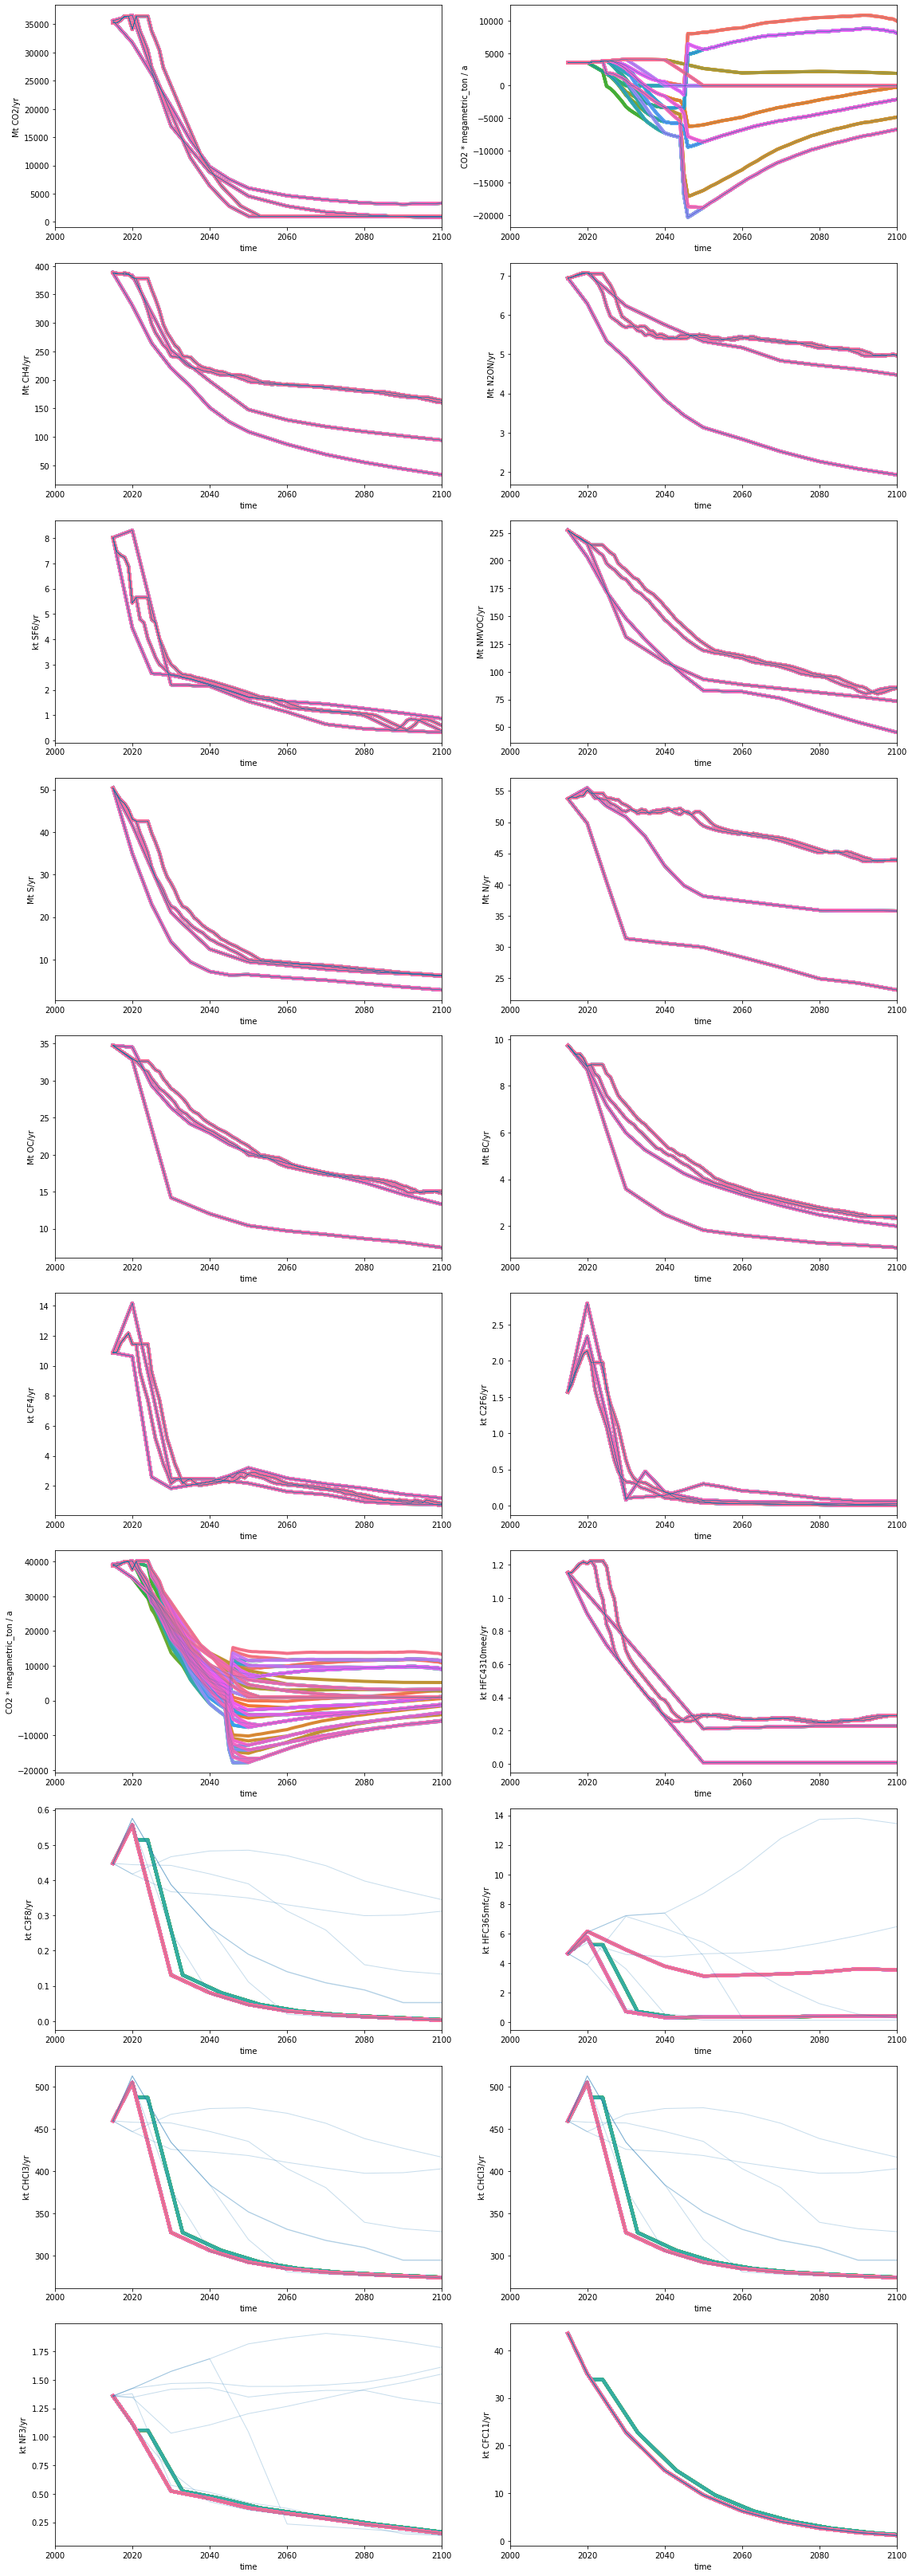

<IPython.core.display.Javascript object>

In [21]:
nrows = 10
fig, axes = plt.subplots(figsize=(16, 4.5 * nrows), nrows=nrows, ncols=2)

crunched_emms_plot = crunched_scenarios_mangled_scenario_name.copy()
crunched_emms_plot = crunched_emms_plot.append(
    crunched_emms_plot.filter(variable="*CO2*AFOLU*").add(
        crunched_emms_plot.filter(variable="*CO2*Fossil*"),
        op_cols={"variable": "Emissions|CO2"},
    )
)
crunched_emms_plot["model_scenario"] = (
    crunched_emms_plot["model"] + "_" + crunched_emms_plot["scenario"]
)

infilled_plot = infilled.copy()
infilled_plot = infilled_plot.append(
    infilled_plot.filter(variable="*CO2*AFOLU*").add(
        infilled_plot.filter(variable="*CO2*Fossil*"),
        op_cols={"variable": "Emissions|CO2"},
    )
)

variable_ax = (
    ("*Emissions|CO2|*Fossil and Industrial", axes[0][0], crunched_emms_plot),
    ("*Emissions|CO2|*AFOLU", axes[0][1], crunched_emms_plot),
    ("*Emissions|CO2", axes[6][0], crunched_emms_plot),
    ("*Emissions|CH4", axes[1][0], crunched_emms_plot),
    ("*Emissions|N2O", axes[1][1], crunched_emms_plot),
    ("*Emissions|SF6", axes[2][0], crunched_emms_plot),
    ("*Emissions|VOC", axes[2][1], crunched_emms_plot),
    ("*Emissions|Sulfur", axes[3][0], crunched_emms_plot),
    ("*Emissions|NH3", axes[3][1], crunched_emms_plot),
    ("*Emissions|OC", axes[4][0], crunched_emms_plot),
    ("*Emissions|BC", axes[4][1], crunched_emms_plot),
    ("*Emissions|CF4", axes[5][0], crunched_emms_plot),
    ("*Emissions|C2F6", axes[5][1], crunched_emms_plot),
    ("*Emissions|HFC43*", axes[6][1], crunched_emms_plot),
    (
        "*Emissions|C3F8",
        axes[7][0],
        scmdata.ScmRun(rcmip_emissions_clean_pyam.timeseries()),
    ),
    (
        "*Emissions|HFC365mfc",
        axes[7][1],
        scmdata.ScmRun(rcmip_emissions_clean_pyam.timeseries()),
    ),
    (
        "*Emissions|CHCl3",
        axes[8][0],
        scmdata.ScmRun(rcmip_emissions_clean_pyam.timeseries()),
    ),
    (
        "*Emissions|CHCl3",
        axes[8][1],
        scmdata.ScmRun(rcmip_emissions_clean_pyam.timeseries()),
    ),
    (
        "*Emissions|NF3",
        axes[9][0],
        scmdata.ScmRun(rcmip_emissions_clean_pyam.timeseries()),
    ),
    (
        "*Emissions|CFC11",
        axes[9][1],
        scmdata.ScmRun(rcmip_emissions_clean_pyam.timeseries()),
    ),
)
for i, (variable, ax, base) in enumerate(tqdman.tqdm(variable_ax)):
    infilled_var = infilled_plot.filter(variable="{}".format(variable))
    infilled_var_unit = infilled_var.get_unique_meta("unit", no_duplicates=True)

    bdf = base.filter(variable="{}".format(variable), log_if_empty=False)
    if bdf.empty:
        bdf = base.filter(variable="{}".format(variable), log_if_empty=False)
    if "model_scenario" not in bdf.meta:
        bdf["model_scenario"] = bdf["model"] + bdf["scenario"]

    plot_years = range(2000, 2101)
    ax = infilled_var.filter(year=plot_years).lineplot(
        hue="scenario",
        style="variable",
        estimator=None,
        ci=None,
        ax=ax,
        legend=False if len(infilled_var.get_unique_meta("scenario")) > 15 else "brief",
        linewidth=4,
        time_axis="year",
        # palette=SCENARIO_PALETTE,
    )
    ax = (
        bdf.filter(year=plot_years)
        .convert_unit(infilled_var_unit)
        .lineplot(
            hue="variable",
            ax=ax,
            units="model_scenario",
            estimator=None,
            ci=None,
            legend=False,
            linewidth=0.25 if len(bdf["model_scenario"].unique()) > 20 else 1,
            alpha=0.25,
            time_axis="year",
            # palette=SCENARIO_PALETTE,
        )
    )
    #     ax.set_title(variable)
    ax.set_xlim([2000, 2100])

plt.tight_layout()

In [22]:
infilled.to_nc(OUT_FILE, dimensions=("scenario",), extras=("model",))
!du -sh {OUT_FILE}
xr.load_dataset(OUT_FILE)

2.9M	/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/processed/harmonised-infilled-scenarios/harmonised-infilled-emissions.nc


<xarray.Dataset>
Dimensions:                                       (time: 89, scenario: 80)
Coordinates:
  * time                                          (time) datetime64[ns] 2015-...
  * scenario                                      (scenario) object 'One Eart...
    model                                         (scenario) object 'One Eart...
Data variables: (12/52)
    Emissions__BC                                 (scenario, time) float64 9....
    Emissions__C2F6                               (scenario, time) float64 1....
    Emissions__C3F8                               (scenario, time) float64 0....
    Emissions__C4F10                              (scenario, time) float64 0....
    Emissions__C5F12                              (scenario, time) float64 0....
    Emissions__C6F14                              (scenario, time) float64 0....
    ...                                            ...
    Emissions__OC                                 (scenario, time) float64 34...
    Emissions__SF6                                (scenario, time) float64 8....
    Emissions__SO2F2                              (scenario, time) float64 2....
    Emissions__Sulfur                             (scenario, time) float64 50...
    Emissions__VOC                                (scenario, time) float64 22...
    Emissions__cC4F8                              (scenario, time) float64 1....
Attributes:
    scmdata_metadata_region:  World
    created_at:               2022-06-01T16:58:55.438299
    _scmdata_version:         0.14.1

<IPython.core.display.Javascript object>